In [107]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import numpy as np

from brokenaxes import brokenaxes

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [108]:
# CSV 파일에 접근
maml_info = pd.read_csv('../MAML_filter64/MAML_filter64_inner_loop_test.csv')
arbiter_info = pd.read_csv('../MAML+Arbiter_5way_5shot_filter64_7150/MAML+Arbiter_5way_5shot_filter64_inner_loop_test.csv')
alfa_info = pd.read_csv('../MAML+ALFA/alfa+maml_inner_loop_test.csv')
l2f_info = pd.read_csv('../MAML+L2F/MAML+L2F_inner_loop_test.csv')

# 훈련 정보만 가지고 온다
maml_info_train = maml_info[maml_info['phase']=='val']
arbiter_info_train= arbiter_info[arbiter_info['phase']=='val']
alfa_info = alfa_info[alfa_info['phase'] == 'val']
l2f_info = l2f_info[alfa_info['phase'] == 'val']

# 1. 정보를 Domain 별로 압축

In [109]:
maml_info_mini_imagenet = maml_info_train[maml_info_train['current_iter']=='mini_imagenet_full_size']
maml_info_mini_imagenet = maml_info_mini_imagenet.groupby('num_step')


maml_info_cifar_fs = maml_info_train[maml_info_train['current_iter']=='CIFAR_FS']
maml_info_cifar_fs = maml_info_cifar_fs.groupby('num_step')

maml_info_CUB = maml_info_train[maml_info_train['current_iter']=='CUB']
maml_info_CUB = maml_info_CUB.groupby('num_step')

In [110]:
# mini-imagenet
arbiter_info_mini_imagenet = arbiter_info[arbiter_info['current_iter']=='mini_imagenet_full_size']
arbiter_info_mini_imagenet = arbiter_info_mini_imagenet.groupby('num_step')

# # tiered-imagenet
# arbiter_info_tiered_imagenet = arbiter_info[arbiter_info['current_iter']=='tiered_imagenet']
# arbiter_info_tiered_imagenet = arbiter_info_tiered_imagenet.groupby('num_step')
# # CIFAR_FS
# arbiter_info_CIFAR_FS = arbiter_info[arbiter_info['current_iter']=='CIFAR_FS']
# arbiter_info_CIFAR_FS = arbiter_info_CIFAR_FS.groupby('num_step')
# # CUB
# arbiter_info_CUB = arbiter_info[arbiter_info['current_iter']=='CUB']
# arbiter_info_CUB = arbiter_info_CUB.groupby('num_step')

# 'layer_dict.conv0.conv.weight_grad_L2norm', 
# 'layer_dict.conv1.conv.weight_grad_L2norm', 
# 'layer_dict.conv2.conv.weight_grad_L2norm',
# 'layer_dict.conv3.conv.weight_grad_L2norm',
# 'layer_dict.linear.weights_grad_L2norm'

Text(0.5, 1.0, 'Loss Distribution')

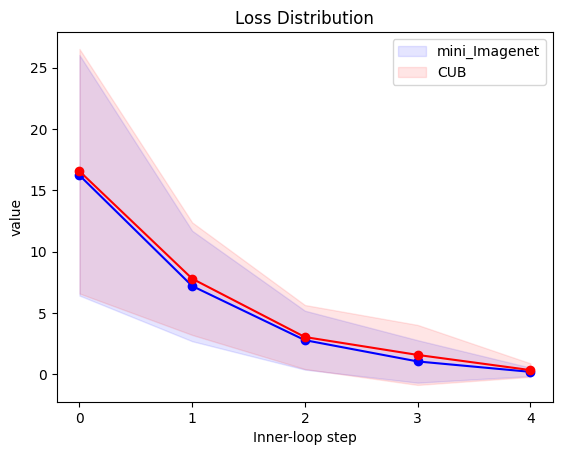

In [111]:
group_names = []

for name, group in maml_info_mini_imagenet:
    # 그룹 이름을 저장 (모든 그룹은 동일한 순서로 추가됨)
    if name not in group_names:
        group_names.append(name)

x = range(len(group_names))
        
maml_miniimagenet_mean_df = maml_info_mini_imagenet['loss_mean'].mean()
maml_cifar_mean_df = maml_info_cifar_fs['loss_mean'].mean()
maml_cub_mean_df = maml_info_CUB['loss_mean'].mean()


maml_miniimagenet_std_devs = maml_info_mini_imagenet['loss_std'].mean()
maml_cifart_std_devs= maml_info_cifar_fs['loss_std'].mean()
maml_cub_std_devs= maml_info_CUB['loss_std'].mean()


plt.plot(x, maml_miniimagenet_mean_df, '-o', color='b')
plt.fill_between(x, maml_miniimagenet_mean_df - maml_miniimagenet_std_devs, maml_miniimagenet_mean_df + maml_miniimagenet_std_devs, color='b', alpha=0.1, label='mini_Imagenet')

# plt.plot(x, maml_cifar_mean_df, '-o', color='r')
# plt.fill_between(x, maml_cifar_mean_df - maml_cifart_std_devs, maml_cifar_mean_df + maml_cifart_std_devs, color='r', alpha=0.1, label='CIFAR-FS')

plt.plot(x, maml_cub_mean_df, '-o', color='r')
plt.fill_between(x, maml_cub_mean_df - maml_cub_std_devs, maml_cub_mean_df + maml_cub_std_devs, color='r', alpha=0.1, label='CUB')

plt.legend()
plt.xticks(x, group_names)
plt.xlabel('Inner-loop step')
plt.ylabel('value')
plt.title('Loss Distribution')

Text(0.5, 1.0, 'Loss Distribution')

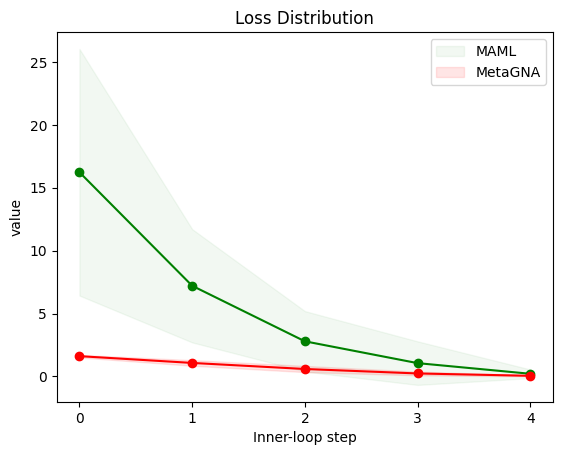

In [120]:
group_names = []

for name, group in maml_info_mini_imagenet:
    # 그룹 이름을 저장 (모든 그룹은 동일한 순서로 추가됨)
    if name not in group_names:
        group_names.append(name)

x = range(len(group_names))
        
maml_mean_df = maml_info_mini_imagenet['loss_mean'].mean()
arbiter_mean_df = arbiter_info_mini_imagenet['loss_mean'].mean()
# alfa_mean_df = alfa_info['loss_mean'].mean()
# l2f_mean_df = l2f_info['loss_mean'].mean()


maml_std_devs = maml_info_mini_imagenet['loss_std'].mean()
arbiter_std_devs= arbiter_info_mini_imagenet['loss_std'].mean()
# alfa_std_devs = alfa_info['loss_std'].mean()
# l2f_std_devs = l2f_info['loss_std'].mean()


# maml_mean_df = np.log(maml_mean_df)
# maml_std_devs = np.log(maml_std_devs)

# arbiter_mean_df = np.log(arbiter_mean_df)
# arbiter_std_devs = np.log(arbiter_std_devs)


plt.plot(x, maml_mean_df, '-o', color='g')#, label='MAML')
plt.fill_between(x, maml_mean_df - maml_std_devs, maml_mean_df + maml_std_devs, color='g', alpha=0.05, label='MAML')

# plt.plot(x, l2f_mean_df, '-o', color='b')#, label='MAML')
# plt.fill_between(x, l2f_mean_df - l2f_std_devs, l2f_mean_df + l2f_std_devs, color='b', alpha=0.1, label='L2F')

# plt.plot(x, alfa_mean_df, '-o', color='b')#, label='MAML')
# plt.fill_between(x, alfa_mean_df - alfa_std_devs, alfa_mean_df + alfa_std_devs, color='b', alpha=0.1, label='ALFA')

plt.plot(x, arbiter_mean_df, '-o', color='r')#, label='MetaGNA')
plt.fill_between(x, arbiter_mean_df - arbiter_std_devs, arbiter_mean_df + arbiter_std_devs, color='r', alpha=0.1, label='MetaGNA')

plt.legend()
plt.xticks(x, group_names)
plt.xlabel('Inner-loop step')
plt.ylabel('value')
plt.title('Loss Distribution')

Text(0.5, 1.0, 'Gradient norm')

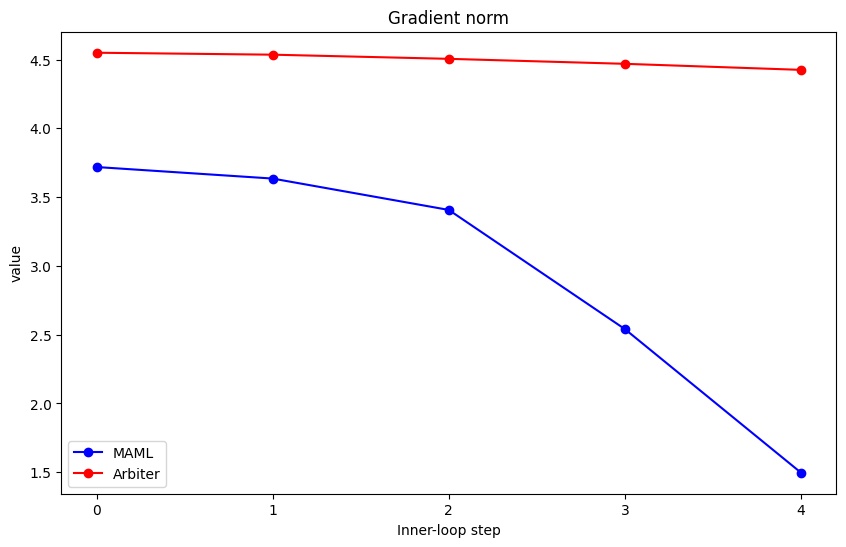

In [112]:
group_names = []

for name, group in maml_info_mini_imagenet:
    # 그룹 이름을 저장 (모든 그룹은 동일한 순서로 추가됨)
    if name not in group_names:
        group_names.append(name)

x = range(len(group_names))
        
maml_mean_df = maml_info_mini_imagenet['all_grads_l2norm'].mean()
# before_arbiter_mean_df = arbiter_info_mini_imagenet['pre_all_grads_l2norm'].mean()
arbiter_mean_df = arbiter_info_mini_imagenet['all_grads_l2norm'].mean()

maml_means = maml_mean_df.values
arbiter_means = arbiter_mean_df.values

# 데이터에 로그 변환 적용
maml_means = np.log(maml_means)
arbiter_means = np.log(arbiter_means)
# arbiter_withoutWN_means = np.log(arbiter_withoutWN_means)

# 꺾은선 그래프를 그립니다
plt.figure(figsize=(10, 6))
plt.plot(x, maml_means, '-o', color='b', label='MAML')
# plt.plot(x, before_arbiter_mean_df, '-o', color='g', label='before_Arbiter')
plt.plot(x, arbiter_means, '-o', color='r', label='Arbiter')

plt.legend()
plt.xticks(x, group_names)
plt.xlabel('Inner-loop step')
plt.ylabel('value')
plt.title('Gradient norm')

Text(0.5, 1.0, 'GSNR')

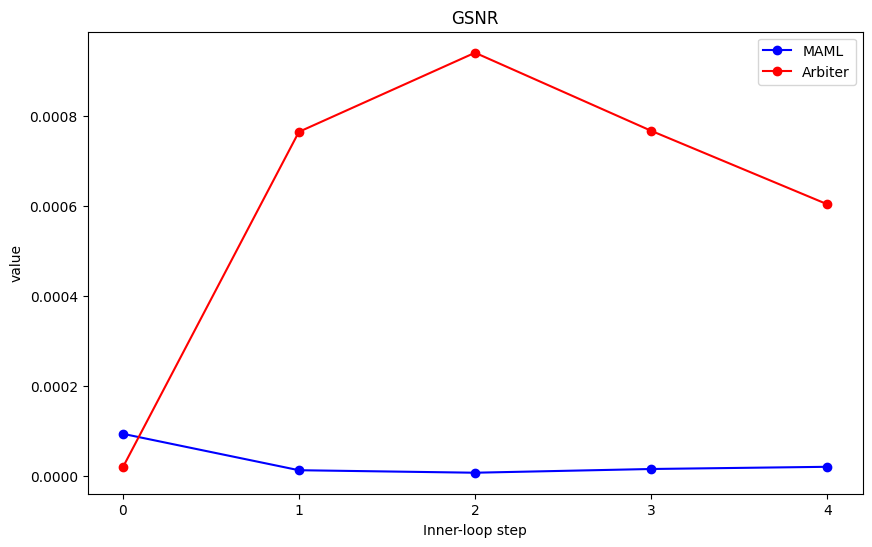

In [113]:
group_names = []

for name, group in maml_info_mini_imagenet:
    # 그룹 이름을 저장 (모든 그룹은 동일한 순서로 추가됨)
    if name not in group_names:
        group_names.append(name)

x = range(len(group_names))
        
maml_mean_df = maml_info_mini_imagenet['gsnr'].mean()
#arbiter_mean_df = arbiter_info_mini_imagenet['pre_gsnr'].mean()
arbiter_mean_df = arbiter_info_mini_imagenet['gsnr'].mean()
# l2f_mean_df = l2f_info['gsnr'].mean()
# alfa_mean_df = alfa_info['gsnr'].mean()

maml_means = maml_mean_df.values
arbiter_means = arbiter_mean_df.values
#l2f_mean_df = l2f_mean_df.values

# 데이터에 로그 변환 적용
# maml_means = np.log(maml_means)
# arbiter_means = np.log(arbiter_means)
# arbiter_withoutWN_means = np.log(arbiter_withoutWN_means)

# 꺾은선 그래프를 그립니다
plt.figure(figsize=(10, 6))
plt.plot(x, maml_means, '-o', color='b', label='MAML')
plt.plot(x, arbiter_means, '-o', color='r', label='Arbiter')
#plt.plot(x, l2f_mean_df, '-o', color='g', label='L2F')
# plt.plot(x, arbiter_withoutWN_means, '-o', color='g', label='Arbiter_withoutWN')
# plt.plot(x, arbiter_withoutGN_means, '-o', color='violet', label='Arbiter_withoutGN')

plt.legend()
plt.xticks(x, group_names)
plt.xlabel('Inner-loop step')
plt.ylabel('value')
plt.title('GSNR')

Text(0.5, 1.0, 'Gradient Varaince')

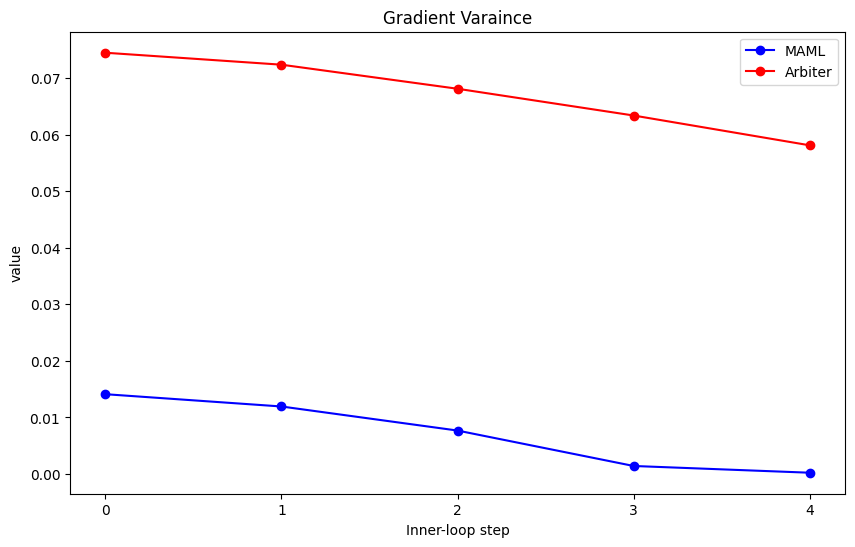

In [114]:
group_names = []

for name, group in maml_info_mini_imagenet:
    # 그룹 이름을 저장 (모든 그룹은 동일한 순서로 추가됨)
    if name not in group_names:
        group_names.append(name)

x = range(len(group_names))
        
maml_mean_df = maml_info_mini_imagenet['all_grads_var'].mean()
# arbiter_mean_df = arbiter_info_mini_imagenet['pre_all_grads_var'].mean()
arbiter_mean_df = arbiter_info_mini_imagenet['all_grads_var'].mean()

maml_means = maml_mean_df.values
arbiter_means = arbiter_mean_df.values

# 데이터에 로그 변환 적용
# maml_means = np.log(maml_means)
# arbiter_means = np.log(arbiter_means)
# arbiter_withoutWN_means = np.log(arbiter_withoutWN_means)

# 꺾은선 그래프를 그립니다
plt.figure(figsize=(10, 6))
plt.plot(x, maml_means, '-o', color='b', label='MAML')
plt.plot(x, arbiter_means, '-o', color='r', label='Arbiter')
# plt.plot(x, arbiter_withoutWN_means, '-o', color='g', label='Arbiter_withoutWN')
# plt.plot(x, arbiter_withoutGN_means, '-o', color='violet', label='Arbiter_withoutGN')

plt.legend()
plt.xticks(x, group_names)
plt.xlabel('Inner-loop step')
plt.ylabel('value')
plt.title('Gradient Varaince')

Text(0.5, 1.0, 'Gradient mean')

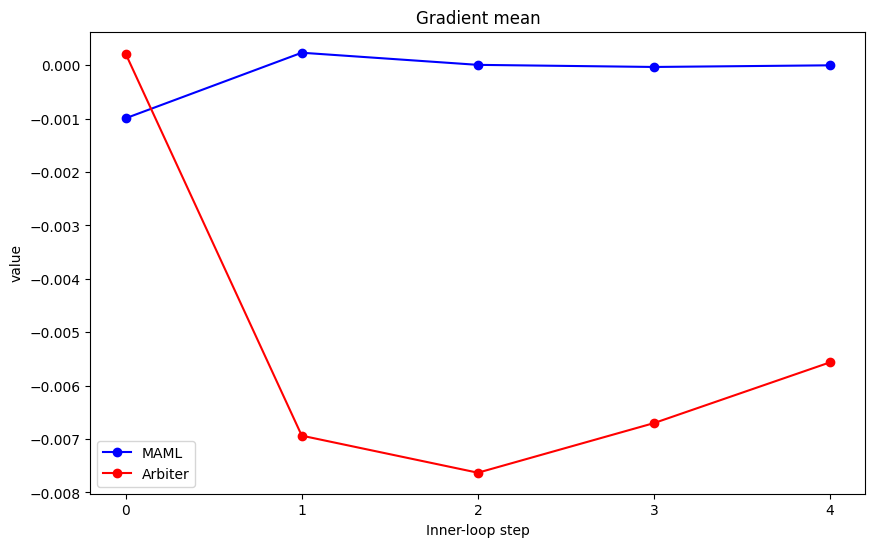

In [115]:
group_names = []

for name, group in maml_info_mini_imagenet:
    # 그룹 이름을 저장 (모든 그룹은 동일한 순서로 추가됨)
    if name not in group_names:
        group_names.append(name)

x = range(len(group_names))
        
maml_mean_df = maml_info_mini_imagenet['all_grads_mean'].mean()
# arbiter_mean_df = arbiter_info_mini_imagenet['pre_all_grads_mean'].mean()
arbiter_mean_df = arbiter_info_mini_imagenet['all_grads_mean'].mean()

maml_means = maml_mean_df.values
arbiter_means = arbiter_mean_df.values

# 데이터에 로그 변환 적용
# maml_means = np.log(maml_means)
# arbiter_means = np.log(arbiter_means)
# arbiter_withoutWN_means = np.log(arbiter_withoutWN_means)

# 꺾은선 그래프를 그립니다
plt.figure(figsize=(10, 6))
plt.plot(x, maml_means, '-o', color='b', label='MAML')
plt.plot(x, arbiter_means, '-o', color='r', label='Arbiter')
# plt.plot(x, arbiter_withoutWN_means, '-o', color='g', label='Arbiter_withoutWN')
# plt.plot(x, arbiter_withoutGN_means, '-o', color='violet', label='Arbiter_withoutGN')

plt.legend()
plt.xticks(x, group_names)
plt.xlabel('Inner-loop step')
plt.ylabel('value')
plt.title('Gradient mean')

Text(0.5, 1.0, 'Weight norm')

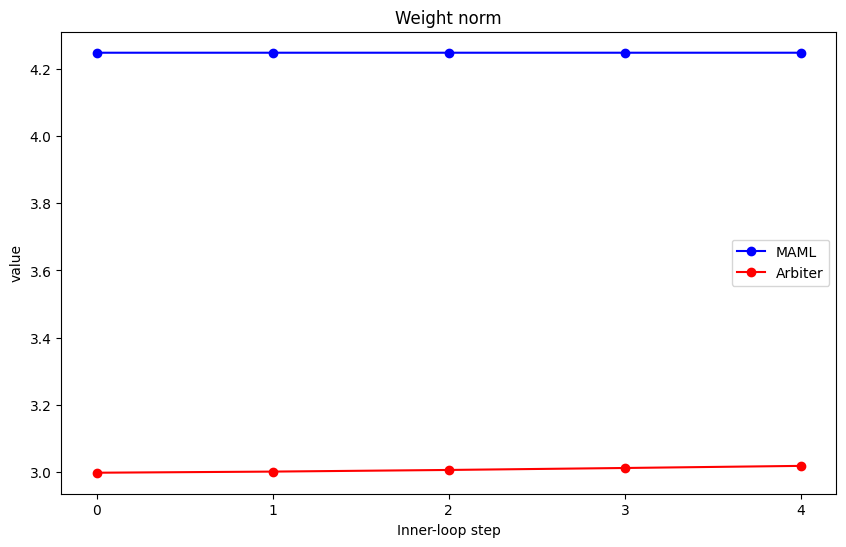

In [116]:
group_names = []

for name, group in maml_info_mini_imagenet:
    # 그룹 이름을 저장 (모든 그룹은 동일한 순서로 추가됨)
    if name not in group_names:
        group_names.append(name)

x = range(len(group_names))
        
maml_mean_df = maml_info_mini_imagenet['all_weights_norm'].mean()
arbiter_mean_df = arbiter_info_mini_imagenet['all_weights_norm'].mean()

maml_means = maml_mean_df.values
arbiter_means = arbiter_mean_df.values

# 데이터에 로그 변환 적용
maml_means = np.log(maml_means)
arbiter_means = np.log(arbiter_means)

# 꺾은선 그래프를 그립니다
plt.figure(figsize=(10, 6))
plt.plot(x, maml_means, '-o', color='b', label='MAML')
plt.plot(x, arbiter_means, '-o', color='r', label='Arbiter')
# plt.plot(x, arbiter_withoutWN_means, '-o', color='g', label='Arbiter_withoutWN')
# plt.plot(x, arbiter_withoutGN_means, '-o', color='violet', label='Arbiter_withoutGN')

plt.legend()
plt.xticks(x, group_names)
plt.xlabel('Inner-loop step')
plt.ylabel('value')
plt.title('Weight norm')

Text(0.5, 1.0, 'Weight variance')

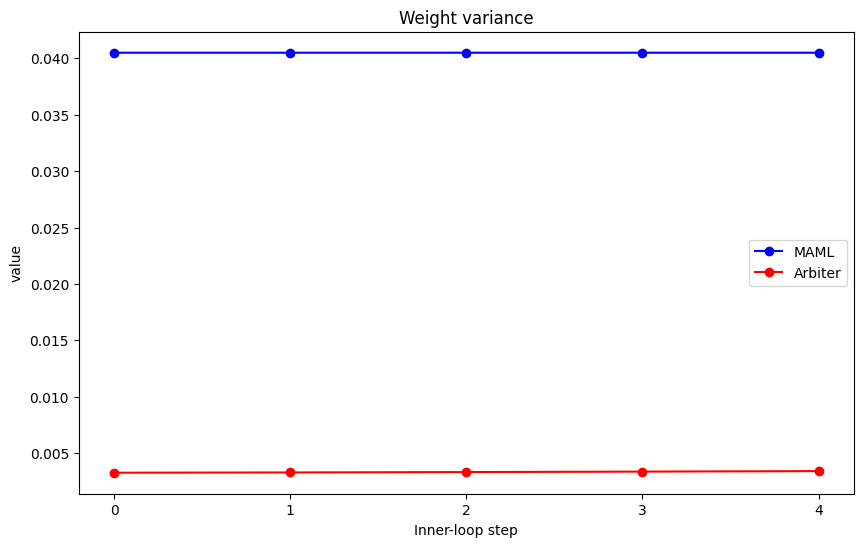

In [117]:
group_names = []

for name, group in maml_info_mini_imagenet:
    # 그룹 이름을 저장 (모든 그룹은 동일한 순서로 추가됨)
    if name not in group_names:
        group_names.append(name)

x = range(len(group_names))
        
maml_mean_df = maml_info_mini_imagenet['all_weights_var'].mean()
arbiter_mean_df = arbiter_info_mini_imagenet['all_weights_var'].mean()

maml_means = maml_mean_df.values
arbiter_means = arbiter_mean_df.values

# 데이터에 로그 변환 적용
# maml_means = np.log(maml_means)
# arbiter_means = np.log(arbiter_means)

# 꺾은선 그래프를 그립니다
plt.figure(figsize=(10, 6))
plt.plot(x, maml_means, '-o', color='b', label='MAML')
plt.plot(x, arbiter_means, '-o', color='r', label='Arbiter')
# plt.plot(x, arbiter_withoutWN_means, '-o', color='g', label='Arbiter_withoutWN')
# plt.plot(x, arbiter_withoutGN_means, '-o', color='violet', label='Arbiter_withoutGN')

plt.legend()
plt.xticks(x, group_names)
plt.xlabel('Inner-loop step')
plt.ylabel('value')
plt.title('Weight variance')